In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv('C://Users/kamel/Downloads/Nasa_Space_Apps_2023/New Folder/Mag_202009.csv')

In [4]:
df.head()

,Unnamed: 0,dsc_time,dsc_bx_gse,dsc_by_gse,dsc_bz_gse,dsc_bx_gsm,dsc_by_gsm,dsc_bz_gsm,wind_bx_gsm,wind_by_gsm,wind_bz_gsm,wind_bx_gse,wind_by_gse,wind_bz_gse,Kp_index
0,0,1.598918e+12,-4.83432,2.70984,2.28954,-4.83432,3.15709,1.61803,-4.926943,1.783888,2.347001,-4.926910,1.219141,2.684156,2.667000
1,1,1.598918e+12,-4.74703,2.64466,2.89804,-4.74703,3.23111,2.22549,-5.043280,1.701327,2.263781,-5.043248,1.157067,2.584713,2.667285
2,2,1.598918e+12,-4.80204,2.84128,2.37969,-4.80204,3.30553,1.67610,-5.076955,1.674740,2.309296,-5.076922,1.121032,2.623209,2.667570
3,3,1.598918e+12,-5.03538,2.26547,2.32653,-5.03538,2.73261,1.75441,-5.060141,1.883296,2.159540,-5.060109,1.357583,2.523431,2.667854
4,4,1.598918e+12,-4.88532,2.38189,2.68457,-4.88532,2.92694,2.07685,-5.060983,1.807573,2.088971,-5.060953,1.299375,2.437838,2.668139


In [5]:
updatedDf = df.iloc[:800000, 8:-1]
updatedDf

,wind_bx_gsm,wind_by_gsm,wind_bz_gsm,wind_bx_gse,wind_by_gse,wind_bz_gse
0,-4.926943,1.783888,2.347001,-4.926910,1.219141,2.684156
1,-5.043280,1.701327,2.263781,-5.043248,1.157067,2.584713
2,-5.076955,1.674740,2.309296,-5.076922,1.121032,2.623209
3,-5.060141,1.883296,2.159540,-5.060109,1.357583,2.523431
4,-5.060983,1.807573,2.088971,-5.060953,1.299375,2.437838
...,...,...,...,...,...,...
799995,-3.287959,-0.291909,-0.097142,-3.287959,-0.237163,-0.195966
799996,-3.275213,-0.320090,-0.105602,-3.275213,-0.260386,-0.214034
799997,-3.256751,-0.322042,-0.078700,-3.256751,-0.271913,-0.189657
799998,-3.227058,-0.323206,-0.096004,-3.227058,-0.266747,-0.206220


In [6]:
def process_input(df, numOfFeatures = 6, numOfDataPoints=70):
    X = []
    y = []
    time = []
    
    dfAsNumpy = df.to_numpy()
    
    for i in range(len(dfAsNumpy) - numOfDataPoints):
        row = [r for r in dfAsNumpy[i : i + numOfDataPoints]]
        X.append(row)
        
        label = dfAsNumpy[i + numOfDataPoints][:numOfFeatures]
        y.append(label)
        
    return np.array(X), np.array(y)

In [7]:
numOfDataPoints = 70
numOfFeatures = 6
X, y = process_input(updatedDf, numOfFeatures, numOfDataPoints)

In [8]:
X.shape, y.shape

((799930, 70, 6), (799930, 6))

In [9]:
def train_test_split(X, y, testPercentage=0.2):
    num_rows = X.shape[0]
    num_test = int(num_rows * testPercentage)
    X_train, X_test = X[:-num_test], X[-num_test:]
    y_train, y_test = y[:-num_test], y[-num_test:]
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.3)

In [11]:
del X
del y

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dropout, Add, Dense, Masking, Flatten
from tensorflow.keras.optimizers import Adam

def transformer_encoder(inputs, d_model, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Dropout(dropout)(attention_output)
    res = Add()([x, inputs])

    # Feed-forward network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dense(d_model)(x)
    x = Dropout(dropout)(x)

    return Add()([x, res])

def transformer_decoder(inputs, target_seq_length, d_model, num_heads, ff_dim, dropout=0.1):
    x = Masking()(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Self-Attention layer (masked self-attention for decoder)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed-forward network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dense(d_model)(x)
    x = Dropout(dropout)(x)

    return Add()([x, res])

# Hyperparameters
d_model = 6
num_heads = 8
ff_dim = 512
input_sequence_length = 70
target_sequence_length = 6

encoder_input_layer = Input(shape=(input_sequence_length, d_model), name='encoder_input')
encoder_output = transformer_encoder(encoder_input_layer, d_model, num_heads, ff_dim)

decoder_output = transformer_decoder(encoder_output, target_sequence_length, d_model, num_heads, ff_dim)

# Flatten and add the Dense layer to reduce the output dimensions
flattened_output = Flatten()(decoder_output)
final_output = Dense(6)(flattened_output)

unified_model = Model(inputs=[encoder_input_layer], outputs=[final_output])

# Compile and train the model
unified_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model summary to see the architecture and output shapes
unified_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 70, 6)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 70, 6)       12          ['encoder_input[0][0]']          
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 70, 6)       1302        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [13]:
unified_model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
17499/17499 [==============================] - 128s 7ms/step - loss: 0.0530
Epoch 2/10
17499/17499 [==============================] - 131s 7ms/step - loss: 0.0330
Epoch 3/10
17499/17499 [==============================] - 222s 13ms/step - loss: 0.0321
Epoch 4/10
17499/17499 [==============================] - 286s 16ms/step - loss: 0.0321
Epoch 5/10
17499/17499 [==============================] - 194s 11ms/step - loss: 0.0322
Epoch 6/10
17499/17499 [==============================] - 134s 8ms/step - loss: 0.0322
Epoch 7/10
17499/17499 [==============================] - 136s 8ms/step - loss: 0.0322
Epoch 8/10
17499/17499 [==============================] - 135s 8ms/step - loss: 0.0323
Epoch 9/10
17499/17499 [==============================] - 132s 8ms/step - loss: 0.0322
Epoch 10/10
17499/17499 [==============================] - 548s 31ms/step - loss: 0.0321


In [14]:
unified_model.save('forecasting_model.h5')

In [15]:
y_pred = unified_model.predict(X_test)

7500/7500 [==============================] - 24s 3ms/step


In [16]:
def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    return mse

In [17]:
mean_squared_error(y_test, y_pred)

0.035172780462669175

In [9]:
testingDf = updatedDf.iloc[:370, :]
testingDf.shape

(370, 6)

In [30]:
X_testing, y_testing = process_input(testingDf)
y_prediction = model.predict(X_testing)

10/10 [==============================] - 0s 14ms/step


In [31]:
y_prediction.shape

(300, 6)

In [32]:
testingDf[70:]['wind_bx_gsm']

70    -5.196113
71    -4.843612
72    -4.926178
73    -4.938103
74    -5.094675
         ...   
365   -3.014256
366   -3.143760
367   -2.875529
368   -3.029810
369   -3.406149
Name: wind_bx_gsm, Length: 300, dtype: float64

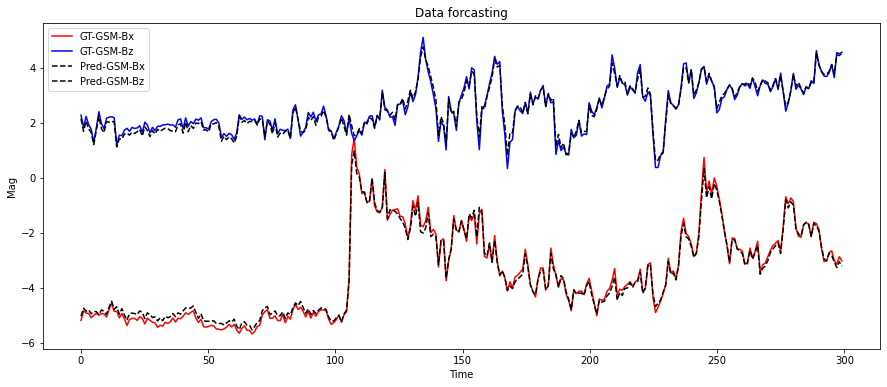

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Create the x-axis values
x_values = np.linspace(0, 299, 299)

plt.figure(figsize = (15,6))
# Plotting the first line with a wider line width
plt.plot(x_values, testingDf[70:-1]['wind_bx_gsm'], label='GT-GSM-Bx', color='r')
plt.plot(x_values, testingDf[70:-1]['wind_bz_gsm'], label='GT-GSM-Bz', color='b')

# Plotting the second line with a dashed line style and wider line width
plt.plot(x_values, y_prediction[1:, 0], label='Pred-GSM-Bx', color='black', linestyle='--')
plt.plot(x_values, y_prediction[1:, 2], label='Pred-GSM-Bz', color='black', linestyle='--')

# Adding title and labels
plt.title('Data forcasting')
plt.xlabel('Time')
plt.ylabel('Mag')

# Adding a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()